In [3]:
!pip install timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.1/549.1 kB 8.0 MB/s eta 0:00:00a 0:00:01


In [25]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import timm
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

In [4]:
class TrainEval:

    def __init__(self, model, train_dataloader, val_dataloader, optimizer, epochs):
        self.model = model
        self.train_dataloader = train_dataloader
        self.val_dataloader = val_dataloader
        self.optimizer = optimizer
        self.epoch = epochs

    def train_fn(self, CurrentEpoch):
        self.model.train()
        total_loss = 0.0
        tk = tqdm(self.train_dataloader, desc="EPOCH" + "[TRAIN]" + str(CurrentEpoch+1)+"/"+str(self.epoch))

        for t, data in enumerate(tk):
            images, labels = data
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            self.optimizer.zero_grad()
            logits, loss = self.model(images, labels)
            loss.backward()
            self.optimizer.step()

            total_loss += loss.item()
            tk.set_postfix({"Loss": "%6f" % float(total_loss / (t + 1))})

        return total_loss / len(self.train_dataloader)

    def eval_fn(self, CurrentEpoch):
        self.model.eval()
        total_loss = 0.0
        tk = tqdm(self.val_dataloader, desc="EPOCH" + "[VALID]" + str(CurrentEpoch + 1) + "/" + str(self.epoch))

        for t, data in enumerate(tk):
            images, labels = data
            images, labels = images.to(DEVICE), labels.to(DEVICE)

            logits, loss = self.model(images, labels)

            total_loss += loss.item()
            tk.set_postfix({"Loss": "%6f" % float(total_loss / (t + 1))})

        return total_loss / len(self.val_dataloader)

    def train(self):
        best_valid_loss = np.inf
        best_train_loss = np.inf
        for i in range(self.epoch):
            train_loss = self.train_fn(i)
            val_loss = self.eval_fn(i)

            if val_loss < best_valid_loss:
                torch.save(self.model.state_dict(), "best-weights.pt")
                print("Saved Best Weights")
                best_valid_loss = val_loss
                best_train_loss = train_loss
        print(f"Training Loss : {best_train_loss}")
        print(f"Valid Loss : {best_valid_loss}")


In [5]:
class Model(nn.Module):

    def __init__(self):
        super().__init__()
        self.model = timm.create_model("resnet18", pretrained=True, num_classes=6)

    def forward(self, images, labels=None):
        logits = self.model(images)

        if labels is not None:
            loss = nn.CrossEntropyLoss()(logits, labels)
            return logits, loss

        return logits


In [21]:
def train_aug():

    return transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(degrees=(-20, +20)),
        transforms.ToTensor()
    ])


def val_aug():

    return transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor()
    ])


class Data:

    def __init__(self, train_dir, val_dir, batch_size):
        self.train_dir = train_dir
        self.val_dir = val_dir
        self.batch_size = batch_size

    def load(self):

        trainset = datasets.ImageFolder(root=self.train_dir, transform=train_aug())
        valset = datasets.ImageFolder(root=self.val_dir, transform=val_aug())

        train_loader = DataLoader(dataset=trainset, batch_size=self.batch_size, shuffle=True)
        val_loader = DataLoader(dataset=valset, batch_size=self.batch_size, shuffle=True)

        return train_loader, val_loader, trainset, valset


In [12]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
LEARNING_RATE = 1e-3
BATCH_SIZE = 32
EPOCHS = 15
VAL_DIR = "/kaggle/input/intel-image-classification/seg_test/seg_test/"
TRAIN_DIR = "/kaggle/input/intel-image-classification/seg_train/seg_train/"

# GET DATA

trainLoader, valLoader, trainset, validset = Data(train_dir=TRAIN_DIR, val_dir=VAL_DIR, batch_size=BATCH_SIZE).load()

# MODEL

ClassifierModel = Model().to(DEVICE)

# TRAINING LOOP

OPTIMIZER = torch.optim.Adam(ClassifierModel.parameters(), lr=LEARNING_RATE)
trainModel = TrainEval(ClassifierModel, trainLoader, valLoader, OPTIMIZER, EPOCHS)
trainModel.train()


EPOCH[VALID]1/15: 100%|██████████| 94/94 [00:25<00:00,  3.69it/s, Loss=0.457789]


Saved Best Weights


EPOCH[VALID]2/15: 100%|██████████| 94/94 [00:12<00:00,  7.81it/s, Loss=0.430400]


Saved Best Weights


EPOCH[VALID]3/15: 100%|██████████| 94/94 [00:11<00:00,  7.90it/s, Loss=0.340653]


Saved Best Weights


EPOCH[VALID]4/15: 100%|██████████| 94/94 [00:12<00:00,  7.58it/s, Loss=0.333696]


Saved Best Weights


EPOCH[VALID]7/15: 100%|██████████| 94/94 [00:12<00:00,  7.75it/s, Loss=0.293715]


Saved Best Weights


EPOCH[VALID]11/15: 100%|██████████| 94/94 [00:12<00:00,  7.82it/s, Loss=0.275162]


Saved Best Weights


EPOCH[VALID]14/15: 100%|██████████| 94/94 [00:11<00:00,  7.94it/s, Loss=0.240057]


Saved Best Weights


EPOCH[VALID]15/15: 100%|██████████| 94/94 [00:12<00:00,  7.82it/s, Loss=0.347301]

Training Loss : 0.1980347620463317
Valid Loss : 0.24005739668265302


In [30]:
def view_classify(img, ps):
    
    classes = ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']

    ps = ps.data.cpu().numpy().squeeze()
    img = img.numpy().transpose(1,2,0)
   
    fig, (ax1, ax2) = plt.subplots(figsize=(10,8), ncols=2)
    ax1.imshow(img)
    ax1.axis('off')
    ax2.barh(classes, ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(classes)
    ax2.set_yticklabels(classes)
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)

    plt.tight_layout()

    return None

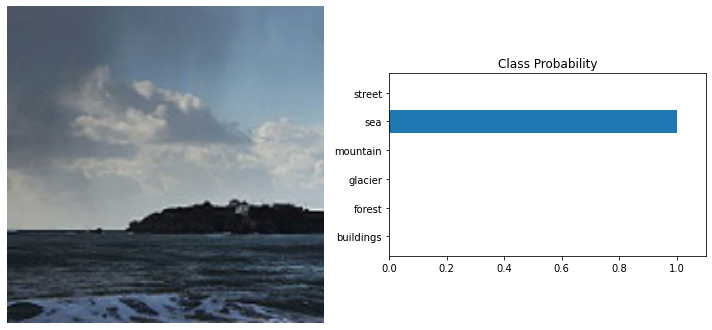

In [34]:
import numpy as np

image, label = validset[np.random.randint(0, len(validset))]

image = image.unsqueeze(0)
logits = ClassifierModel(image.to(DEVICE))
probs = nn.Softmax(dim=1)(logits)

view_classify(image.squeeze(), probs)